# Parallel Affine invariant ensemble sampler with Mixing stages (pyPAM)
### August George, Zuckerman Lab, OHSU, 2023

#### Toy model system: 2D Rosenbrock function

$f(x_0, x_1) = -( (a - x_0)^2 + b(x_1 - x_0^2)^2 )$
$\quad$ where $\quad a = 1.0 \quad$ and $\quad b = 100$

The Rosenbrock function has a curved valley shape in 2D and is a non-convex function which is challenging to optimize/sample from. 

This makes it a good example to test sampler performance on. 

#### import packages and plot 2D Rosenbrock surface

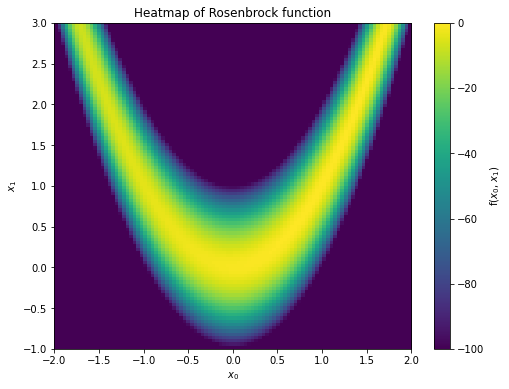

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import emcee 
import sys 
import os
import time
import multiprocessing as mp

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from pyPAM import parallel_affine_utility as pau
from pyPAM import parallel_affine as pa
import toy_model

# set Rosenbrock 'a' and 'b' parameters and create meshgrid for x0 and x1
ab_values = [1,100]
x0 = np.linspace(-2,2,100)
x1 = np.linspace(-1,3,100)
X,Y = np.meshgrid(x0,x1)

# Calculate the Rosenbrock function values
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = toy_model.log_prob((X[i, j], Y[i, j]), *ab_values)

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(Z, cmap='viridis', origin='lower', extent=[-2, 2, -1, 3], aspect='auto',vmin=-100, vmax=0)
plt.colorbar(label=r'f($x_0$, $x_1$)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Heatmap of Rosenbrock function')
plt.show()

#### Run the parallelized affine invariant ensemble sampler with mixing and plot results

2850.9106925531983 samples per second per core
runtime: 35.07651090621948 sec for 400000 total samples using 4 parallel processes

shape of flattened data (n ensembles, n mixing stages, n_steps*n_walkers, n_dim): (4, 10, 10000, 2)
example .h5 datafile:
dict_keys(['stage_0_ensemble_0', 'stage_1_ensemble_0', 'stage_2_ensemble_0', 'stage_3_ensemble_0', 'stage_4_ensemble_0', 'stage_5_ensemble_0', 'stage_6_ensemble_0', 'stage_7_ensemble_0', 'stage_8_ensemble_0', 'stage_9_ensemble_0'])
stage_0_ensemble_0 data shape (n walkers*n_steps,n_dim): (10000, 2)
stage_1_ensemble_0 data shape (n walkers*n_steps,n_dim): (10000, 2)
stage_2_ensemble_0 data shape (n walkers*n_steps,n_dim): (10000, 2)
stage_3_ensemble_0 data shape (n walkers*n_steps,n_dim): (10000, 2)
stage_4_ensemble_0 data shape (n walkers*n_steps,n_dim): (10000, 2)
stage_5_ensemble_0 data shape (n walkers*n_steps,n_dim): (10000, 2)
stage_6_ensemble_0 data shape (n walkers*n_steps,n_dim): (10000, 2)
stage_7_ensemble_0 data shape (n walker

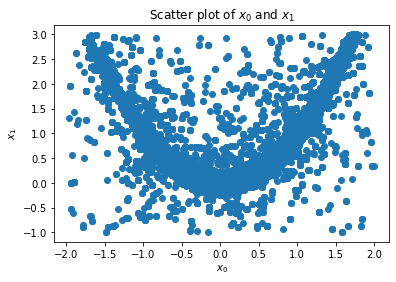

In [2]:
# sampling parameters 
np.random.seed(0)
n_dim = 2
n_ensembles = 4
n_walkers = 100  # n walkers per ensemble --> (n ensembles * n walkers) total walkers 
n_mixing_stages = 10
n_steps_list = [100 for _ in range(n_mixing_stages)]  # number of steps for each mixing stage
n_total_samples = np.sum(np.array(n_steps_list))*n_walkers*n_ensembles  # total number of samples collected
burn_in = int(n_total_samples/4)

log_prob_args = [1,100]  # additional arguments for log probability function f(x,*args)
n_cores = n_ensembles  # one ensemble / process

# initial start points w/ shape = (n_ensembles, n_walkers, n_dim)
x0_range = np.random.uniform(-2, 2, size=(n_ensembles, n_walkers, 1))
x1_range = np.random.uniform(-1, 3, size=(n_ensembles, n_walkers, 1))
p_0 = np.concatenate((x0_range, x1_range), axis=2)

# set backend filenames for each ensemble
backend_fnames = [f'example_data_{i}.h5' for i in range(n_ensembles)]

# set move set for each ensemble
moves = [[
    (emcee.moves.StretchMove(), 0.8),
    (emcee.moves.DESnookerMove(), 0.2),
] for i in range(n_ensembles)]

# set run labels for each mixing stage
run_id_list = [ f'stage_{i}' for i in range(n_mixing_stages)]

# run parallel sampler (w/ mixing) and time it
t0 = time.time()
sampler = pa.ParallelEnsembleSampler(n_ensembles, n_walkers, n_dim, toy_model.log_prob, log_prob_args,  backend_fnames, moves)
states = sampler.run_mixing_sampler(p_0, n_steps_list, n_cores, n_mixing_stages, run_id_list)
t = time.time()-t0 
print(f'{(n_total_samples/t)/n_cores} samples per second per core')
print(f'runtime: {t} sec for {n_total_samples} total samples using {n_cores} parallel processes\n')


# get data 
D = pau.get_data_all_runs(sampler, flat=True)
print(f'shape of flattened data (n ensembles, n mixing stages, n_steps*n_walkers, n_dim): {np.shape(D)}')

pau.plot_single_ensemble_mixing_distributions(sampler,fname='',xlim=[[-2, 2],[-1, 3]])

# open existing .h5 data and analyze it (optional)
print(f'example .h5 datafile:')
datafile_ensemble1 = backend_fnames[0]
data_dict_ensemble1 = pau.get_data_dict_from_backend(datafile_ensemble1,flat=True)
print(data_dict_ensemble1.keys())  # dictionary key = different mixing 'stages'
for key in data_dict_ensemble1.keys():
    print(f'{key} data shape (n walkers*n_steps,n_dim): {np.shape(data_dict_ensemble1[key])}')  # flattened array of data (since flat = True above)

# reshape data and plot scatter plot
reshaped_data = np.array(D).reshape(n_total_samples, n_dim)
x0_samples = reshaped_data[burn_in:, 0]
x1_samples = reshaped_data[burn_in:, 1]

plt.scatter(x0_samples, x1_samples)
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.title(r"Scatter plot of $x_0$ and $x_1$")
plt.show()


# Clean up test files (removes h5 files)
for fname in backend_fnames:
    if os.path.exists(fname):
        os.remove(fname)